In [10]:
import sys, platform, os
import numpy as np
import camb
import pandas as pd
import healpy as hp
from camb import model, initialpower
import useful_functions as uf
import pysm3
from fgbuster import (CMB, Dust, Synchrotron, basic_comp_sep,get_observation, get_instrument, get_sky)
from fgbuster.visualization import corner_norm
nside_patch = 16
nside=16
nside_compsep=nside_patch

instrument = get_instrument('LiteBIRD')
kind_of_map='d1s1'

#sky_vary = get_sky(NSIDE_PATCH, kind_of_map)
sky_vary = get_sky(nside, kind_of_map)

for spectral_param in [sky_vary.components[0].mbb_index,
                       sky_vary.components[0].mbb_temperature,
                       sky_vary.components[1].pl_index]:
    spectral_param[:] = hp.ud_grade(hp.ud_grade(spectral_param.value, nside_patch),
                                    nside) * spectral_param.unit
    print(spectral_param.unit)

unit=-3 #uk->mk 
sync_freq_maps = get_observation(instrument, sky_vary, noise=False, nside=nside,unit='mK_CMB') #, unit='uK_CMB')
print(sync_freq_maps[0])

/home/amorelli/fgbuster/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return df.dropna(1, 'all')



K

[[ 1.09102530e-02  9.59531218e-03  1.08918240e-02 ...  1.25220995e-02
   1.35283666e-02  1.19711235e-02]
 [-1.11671654e-03  3.04641289e-05 -5.00316732e-04 ...  1.01135066e-03
  -1.10723672e-03  8.27770389e-04]
 [-7.54770590e-04  1.13695406e-03 -6.20776205e-04 ...  1.72155473e-04
   3.64485371e-04 -8.77475133e-04]]


In [11]:
#hp.mollview(sync_freq_maps[0,0])
#hp.mollview(sync_freq_maps[0,1])
#hp.mollview(sync_freq_maps[0,2])
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = 12, 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


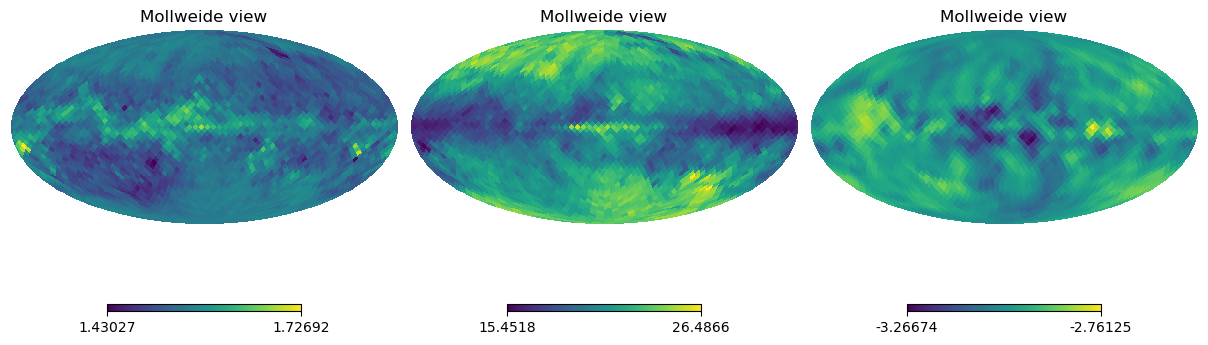

In [12]:
hp.mollview(sky_vary.components[0].mbb_index,sub=(1,3,1))
hp.mollview(sky_vary.components[0].mbb_temperature,sub=(1,3,2))
hp.mollview(sky_vary.components[1].pl_index,sub=(1,3,3))
mbb_index_mean=np.mean(np.abs(sky_vary.components[0].mbb_index))
mbb_temp_mean=np.mean(np.abs(sky_vary.components[0].mbb_temperature))
pl_mean=np.mean(np.abs(sky_vary.components[1].pl_index))

In [18]:
seed_test=70
np.random.seed(seed_test)# i set a seed for the generation of the maps and the a_lm. I use a seed for reproducibility.

n_maps=1
n_channels=2
pol=2

sensitivities=instrument["depth_p"]

n_freq=len(sensitivities)
n_pix=hp.nside2npix(nside)

r=np.ones(1)*0.01
data=uf.generate_cl(n_spectra=1,Nside=512,Nside_red=nside,tau_interval=[0.06,0.06],r_interval=[0.01,0.01], raw=False)

beam_w=2*hp.nside2resol(nside, arcmin=False)

components = [CMB(), Dust(150.), Synchrotron(20.)]
print(components[0])
print(components[1])

# The starting point of the fit is the pysm default value, so let's shift it
#components[1].defaults = [1.6, 22.]
#components[2].defaults = [-2.7]

noise_maps=np.ones(shape=(n_freq,n_maps,n_pix,n_channels*pol))
noise_maps_T=np.ones(shape=(n_freq,n_maps,n_pix,n_channels))
for i,s in enumerate(sensitivities):
    corr=np.sqrt(2)
    noise=uf.generate_noise_maps(n_maps,n_channels,nside,pol=2,sensitivity=s*corr)#if i consider half of the execution time the error increases
    #you can prove it using S/N formula
    noise_T=uf.generate_noise_maps(n_maps,n_channels,nside,pol=1, sensitivity=s*corr/np.sqrt(2))
    noise_maps[i]=noise
    noise_maps_T[i]=noise_T

noise=noise_maps[0]*0.0
noise_T=noise_maps_T[0]*0.0

maps_per_cl_gen=uf.maps_per_cl(distribution=0)
maps_per_cl=maps_per_cl_gen.compute_maps_per_cl(r,n_train=n_maps,n_train_fix=n_maps)

QU_maps=uf.generate_maps(data=data, r=r,n_train=n_maps,nside=16, map_per_cl=maps_per_cl, 
                         noise_maps=noise, beam_w=beam_w, kind_of_map="QU", raw=1, n_channels=2, beam_yes=1 , verbose=0)[0]
T_maps=uf.generate_maps(data=data, r=r,n_train=n_maps,nside=16, map_per_cl=maps_per_cl, 
                         noise_maps=noise_T, beam_w=beam_w, kind_of_map="TT", raw=1, n_channels=2, beam_yes=1 , verbose=0)[0]

#freq_maps=np.ones(shape=(n_channels,n_maps,n_freq,pol,n_pix)) #comp_sep wants n_channels as first dimension, also i cannot
#put polarization in the n_channel dimension -> i break my conventions
freq_maps=np.ones(shape=(n_channels,n_maps,n_freq,3,n_pix))
for i in range(n_maps):
    for j in range(n_freq):
        # freq_maps[j,i,0]=noise_maps_T[i,j]+sync_freq_maps[i,0]+T_maps[j,:,0]
        # freq_maps[j,i,1]=noise_maps[i,j]+sync_freq_maps[i,1]+QU_maps[j,:,0]
        # freq_maps[j,i,2]=noise_maps[i,j]+sync_freq_maps[i,2]+QU_maps[j,:,1]
        for k in range(n_channels):
            freq_maps[k,i,j,0,:]=noise_maps_T[j,i,:,k]*10**unit+sync_freq_maps[j,0]+T_maps[i,:,k]*10**unit
            freq_maps[k,i,j,1,:]=noise_maps[j,i,:,k*n_channels]*10**unit+sync_freq_maps[j,1]+QU_maps[i,:,k*n_channels]*10**unit
            freq_maps[k,i,j,2,:]=noise_maps[j,i,:,k*n_channels+1]*10**unit+sync_freq_maps[j,2]+QU_maps[i,:,k*n_channels+1]*10**unit

result = np.ones(shape=(n_maps,n_pix,n_channels*pol))
#result = np.ones(shape=(n_maps,3,n_pix))
import time
start_time = time.time()
for i in range(n_maps):
    for k in range(n_channels):
        compsep_tot=basic_comp_sep(components, instrument, freq_maps[k,i],nside=nside_compsep) #nside=0 is default
        compsep=compsep_tot.s[0]
        for p in range(pol):
            result[i,:,k*pol+p]=compsep[p+1]-QU_maps[i,:,k*pol+p]*10**unit
print("--- %s seconds ---" % (time.time() - start_time))

1
315707.4030453475*(0.00666666666666667*nu)**(beta_d + 1)*(exp(7.19886461004933/temp) - 1)*expm1(0.01760867023799751*nu)**2*exp(-0.01760867023799751*nu)/(nu**2*(exp(0.0479924307336622*nu/temp) - 1)*expm1(2.641300535699627)**2)
--- 105.53255224227905 seconds ---


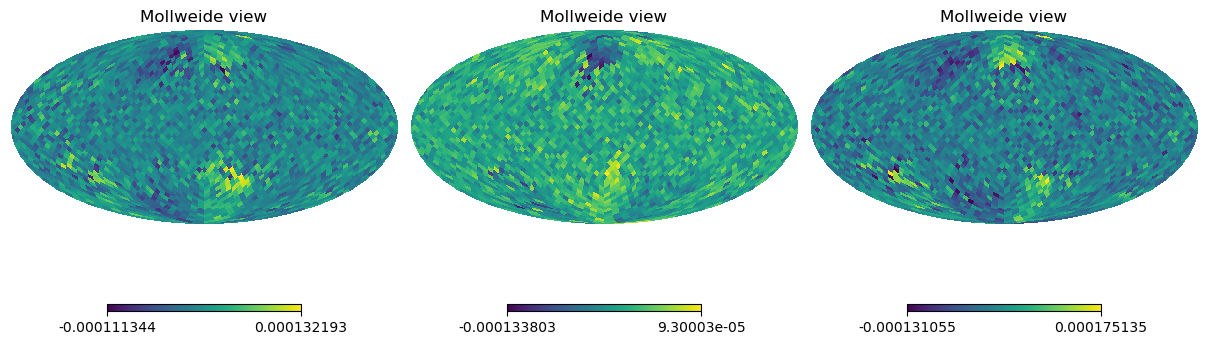

In [19]:
hp.mollview(result[0,:,0],sub=(1,3,1))#,norm="hist")#,min=-1.5,max=1.5)
hp.mollview(result[0,:,1],sub=(1,3,2))#,norm="hist")#,min=-1.5,max=1.5)
hp.mollview(result[0,:,0]-result[0,:,1],sub=(1,3,3))
#hp.mollview(result[0,:,0]+QU_maps[0,:,0])
#hp.mollview(QU_maps[0,:,0]*10**unit,sub=(1,2,2))
#hp.mollview(QU_maps[0,:,0]+result[0,:,0],norm="hist")#,min=-1.5,max=1.5)
#hp.mollview(result[0,:,1],norm="hist")
#hp.mollview(result[0,:,1]-result[0,:,0],norm="hist")

In [20]:
print(compsep_tot.params)

['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']


3072
3072
3072


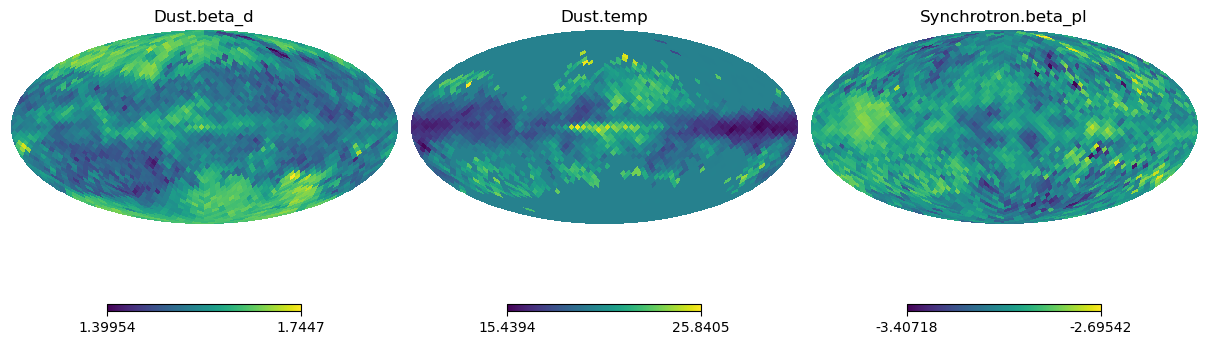

In [21]:
for i, par in enumerate(compsep_tot.params):
    print(len(compsep_tot.x[1]))
    hp.mollview(compsep_tot.x[i], title=par, sub=(1,3,i+1)) #you see that in this case you have one index for each healpix pixel while
    #for d0s0 case you had only one

0.018605038017497466 0.055681016381365876 1 / K 0.02061315814598369
1.5396922826766968 20.928674697875977 K 2.99999737739563


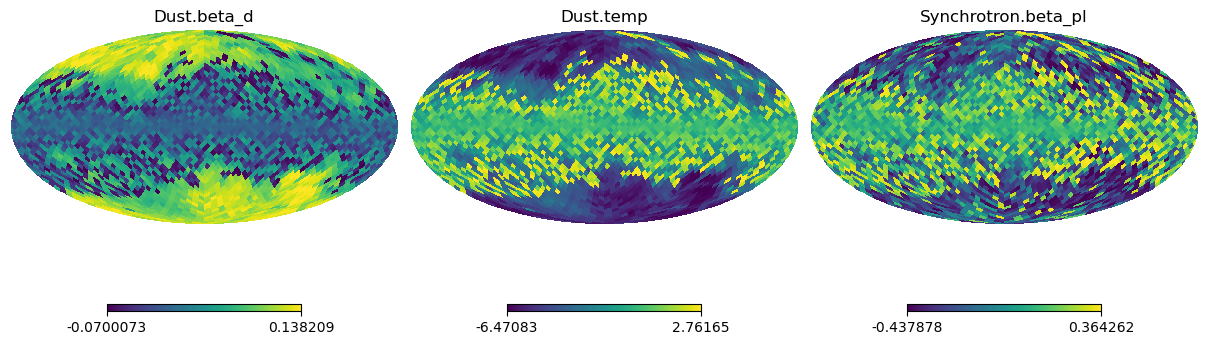

In [22]:
mbb_index_map=hp.ud_grade(compsep_tot.x[0], nside) - sky_vary.components[0].mbb_index
hp.mollview(mbb_index_map,
            title=compsep_tot.params[0], norm='hist', sub=(1,3,1))
mbb_temp_map=hp.ud_grade(compsep_tot.x[1], nside) - sky_vary.components[0].mbb_temperature.value
hp.mollview(mbb_temp_map,
            title=compsep_tot.params[1], norm='hist', sub=(1,3,2))
pl_map=hp.ud_grade(compsep_tot.x[2], nside) - sky_vary.components[1].pl_index
hp.mollview(pl_map,
            title=compsep_tot.params[2], norm='hist', sub=(1,3,3))
print(np.mean(np.abs(mbb_index_map))/mbb_index_mean,
      np.mean(np.abs(mbb_temp_map))/mbb_temp_mean,
      np.mean(np.abs(pl_map))/pl_mean)
print(mbb_index_mean,
      mbb_temp_mean,
      pl_mean)

In [23]:
result*=10**-unit
res=hp.nside2resol(nside, arcmin=True)
mean_Q=np.mean(result[0,:,0])
std_Q=np.std(result[0,:,0])
sensitivity_Q=std_Q*res
print(mean_Q,std_Q,sensitivity_Q)

0.002274295010809893 0.02877695613549907 6.327221873726246


In [24]:
mean_U=np.mean(result[0,:,1])
std_U=np.std(result[0,:,1])
sensitivity_U=std_U*res
print(mean_U,std_U,sensitivity_U)

0.0004988717406029982 0.025801626524838476 5.6730327890476895


In [25]:
E_maps, B_maps = uf.convert_to_EB(result)

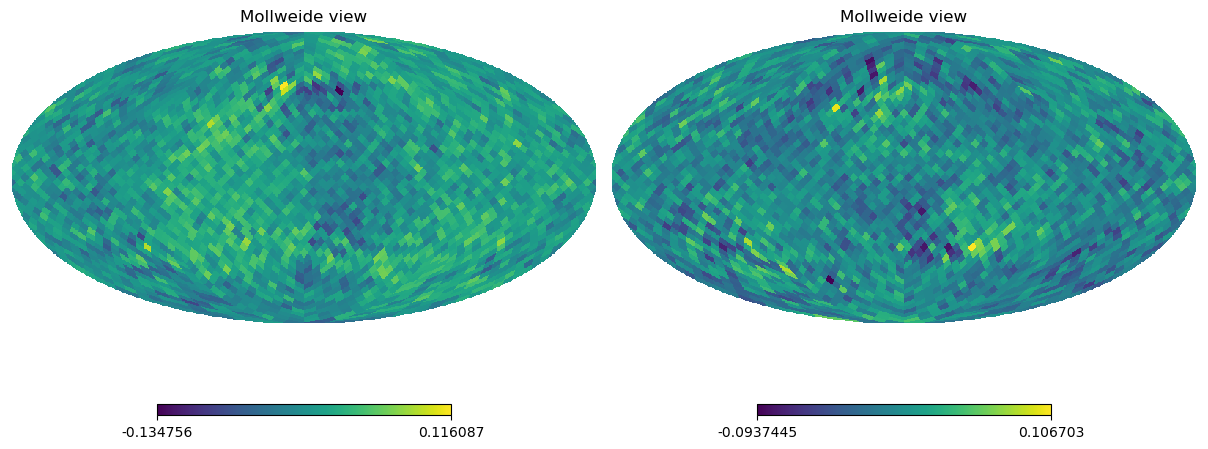

In [26]:
hp.mollview(E_maps[0,:,0], sub=(1,2,1))
hp.mollview(B_maps[0,:,0], sub=(1,2,2))
#hp.mollview(E_maps[0,:,0]-B_maps[0,:,0])

In [27]:
mean_E=np.mean(E_maps[0,:,0])
std_E=np.std(E_maps[0,:,0])
sensitivity_E=std_E*res
print(mean_E,std_E,sensitivity_E)

7.266653472417764e-06 0.02574395395236429 5.660352255347234


In [28]:
mean_B=np.mean(B_maps[0,:,0])
std_B=np.std(B_maps[0,:,0])
sensitivity_B=std_B*res
print(mean_B,std_B,sensitivity_B)

2.556586945753776e-07 0.023054987726303693 5.069126211733338


In [9]:
pol=2
n_maps, n_pix, n_channels = (result.shape[0],result.shape[1],int(result.shape[2]/pol))
nside=hp.npix2nside(n_pix)
#print(n_maps,n_pix,nside,n_channels)
result_2=np.empty_like(result)
mappe_placeholder=np.zeros((n_maps,n_pix))
for i in range(n_maps):
    for k in range(n_channels):
        alm=hp.map2alm([mappe_placeholder[i,:],result[i,:,k*pol],result[i,:,k*pol+1]], pol=True, verbose=True)
        mappp, result_2[i,:,k*n_channels],result_2[i,:,k*n_channels+1]=hp.alm2map(alm, nside, pol=True, verbose=True)

In [10]:
mean_Q2=np.mean(result_2[0,:,0])
std_Q2=np.std(result_2[0,:,0])
sensitivity_Q2=std_Q2*res
print(mean_Q2,std_Q2,sensitivity_Q2)

-0.24785665325133222 0.9666458447523871 212.53751453994136


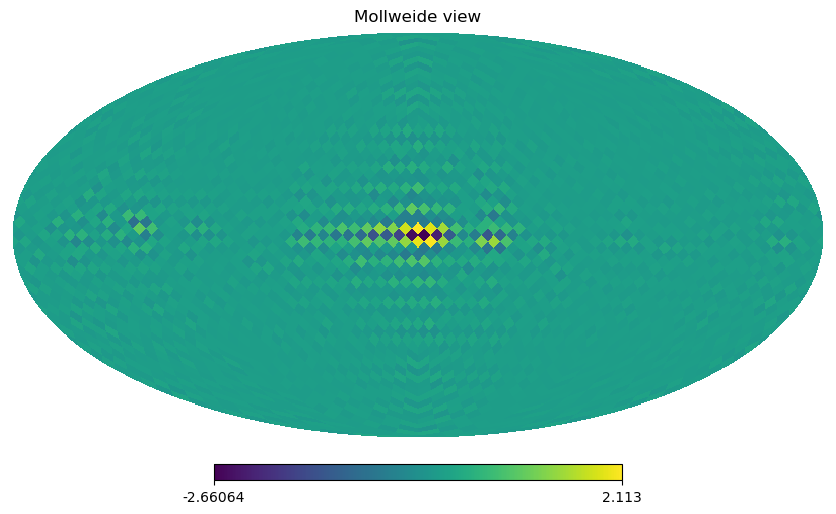

In [11]:
hp.mollview(result[0,:,0]-result_2[0,:,0])

In [12]:
beam_w=0.01*hp.nside2resol(nside, arcmin=False)
lmax=len(data[0,0,:])
print(lmax)
beam=hp.gauss_beam(beam_w, lmax=lmax)
pol=2
result_3=np.empty_like(result)
for i in range(n_maps):
    for k in range(n_channels):
        alm=hp.map2alm([mappe_placeholder[i,:],hp.smoothing(result[i,:,k*pol],fwhm=beam_w)
                        ,hp.smoothing(result[i,:,k*pol+1],fwhm=beam_w)]
                        , pol=True, verbose=True)
        #alm_wb = np.array([hp.almxfl(each,beam) for each in alm]) #i multiply the alm by the window functions
        mappp, result_3[i,:,k*n_channels],result_3[i,:,k*n_channels+1]=hp.alm2map(alm, nside, pol=True, verbose=True)

47


In [13]:
mean_Q3=np.mean(result_3[0,:,0])
std_Q3=np.std(result_3[0,:,0])
sensitivity_Q3=std_Q3*res
print(mean_Q3,std_Q3,sensitivity_Q3)

-0.24784130919152036 0.9665606713615779 212.51878737022784


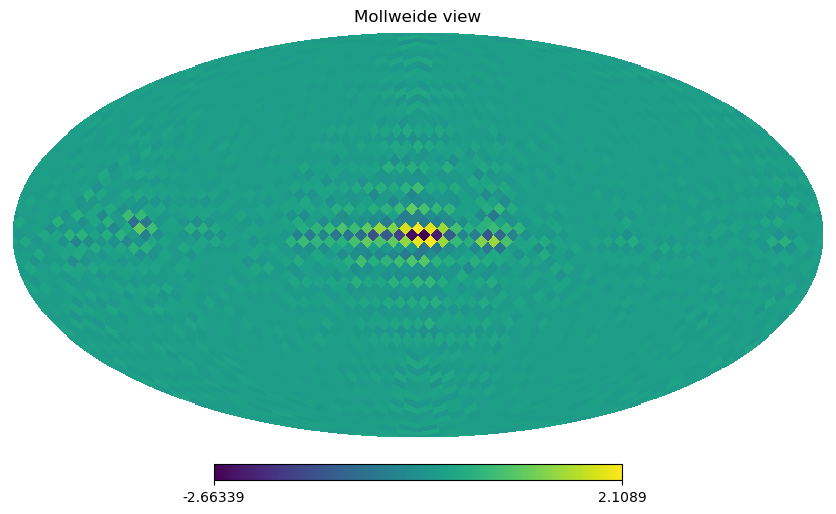

In [14]:
hp.mollview(result[0,:,0]-result_3[0,:,0])

In [15]:
pol=2
result_4=np.empty_like(result)
mappe_placeholder=np.zeros((n_maps,n_pix))
for i in range(n_maps):
    for k in range(n_channels):
        cl=hp.anafast([hp.remove_monopole(mappe_placeholder[i,:]),
                           hp.remove_monopole(result[i,:,k*pol]),hp.remove_monopole(result[i,:,k*pol+1])],lmax=lmax-1,pol=True)
        alm= hp.synalm((cl[0], cl[1], cl[2], cl[3]), lmax=lmax, new=True)
        mappp, result_4[i,:,k*n_channels],result_4[i,:,k*n_channels+1]=hp.alm2map(alm, nside, pol=True, verbose=True)

In [16]:
mean_Q4=np.mean(result_4[0,:,0])
std_Q4=np.std(result_4[0,:,0])
sensitivity_Q4=std_Q4*res
print(mean_Q4,std_Q4,sensitivity_Q4)

0.21509113343814357 0.684577399066338 150.51880654910119


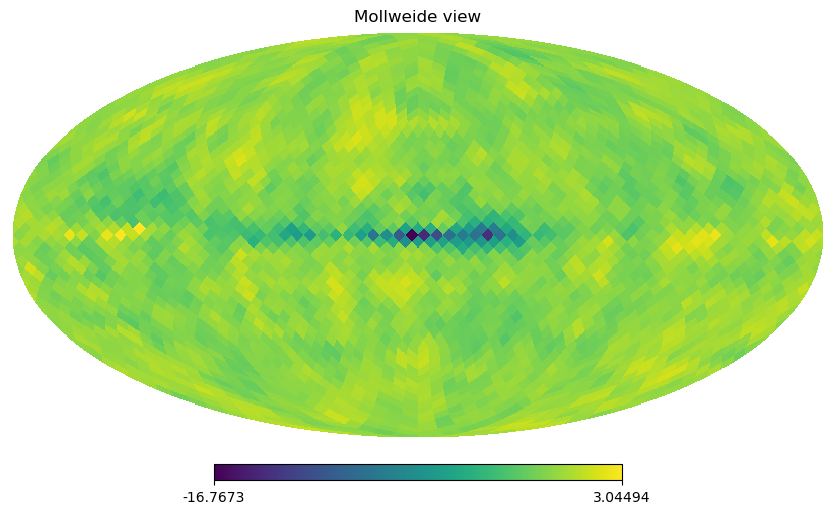

In [17]:
hp.mollview(result[0,:,0]-result_4[0,:,0])